In [1]:
import io
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
from scipy.spatial import cKDTree
import pyproj

import rasterio
from rasterio import Affine
from rasterio.transform import from_origin

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["figure.dpi"] = 130
from mpl_toolkits.axes_grid1 import make_axes_locatable

import harmonica as hm
import boule as bl
import verde as vd

In [2]:
# .csv gravimetric data file path
file_path = '../data/raw/grav_data/dados_brutos.csv'

# .shp file path
shp_pr = '../data/raw/masks/PR_Contorno.shp'
shp_mask = '../data/raw/masks/PR_mascara.shp'

# Load files
gdata = pd.read_csv(file_path)
pr = gpd.read_file(shp_pr)
mask = gpd.read_file(shp_mask)

gdata

,LAT,LONG,layer,h,g,x,y
0,-23.78981,-53.96707,ANP,235,978773.80,5003356,7367991
1,-23.79020,-53.96619,ANP,248,978771.12,5003446,7367947
2,-23.79059,-53.96530,ANP,258,978768.55,5003536,7367904
3,-23.79098,-53.96442,ANP,268,978766.35,5003626,7367861
4,-23.79137,-53.96353,ANP,276,978764.52,5003717,7367818
...,...,...,...,...,...,...,...
32632,-24.71927,-48.83171,UFPR_Tiago,142,978852.29,5522795,7255181
32633,-24.74963,-48.85309,UFPR_Tiago,181,978846.16,5520506,7251891
32634,-24.78023,-48.88414,UFPR_Tiago,287,978835.15,5517241,7248610
32635,-24.67021,-48.82683,UFPR_Tiago,140,978833.64,5523494,7260611


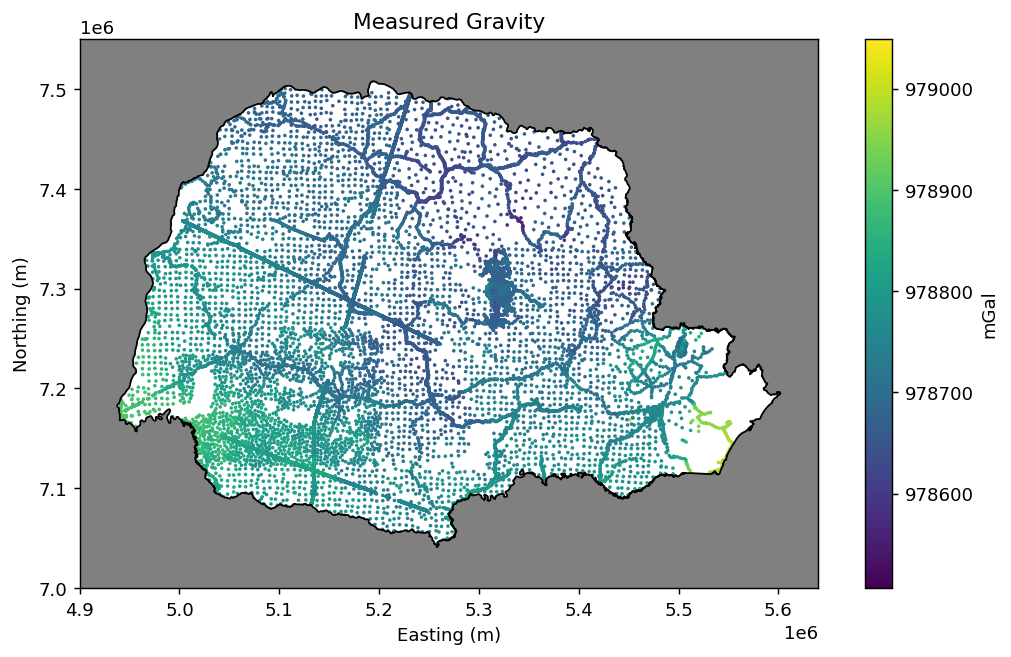

In [3]:
# zoom limits
xmin, xmax, ymin, ymax = 4.9e6, 5.64e6, 7e6, 7.55e6

df_definer = gdata
x_definer = df_definer['x']
y_definer = df_definer['y']
c_definer = df_definer['g']
unit_definer = 'mGal'
title_definer = 'Measured Gravity'


# Plot LTD
fig, ax = plt.subplots(figsize=(8, 5))
tmp = plt.scatter(x_definer, y_definer, c=c_definer, s=1)
mask.plot(ax=ax, color='gray', edgecolor='none')
pr.plot(ax=ax, color='none', edgecolor='black')
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label=unit_definer)
ax.set_title(title_definer)
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

# Analysis of the Distance to the Nearest Neighbor Between Stations

In [4]:
## Determining the Optimal Resolution for Gravimetric Data Gridding

# Extract x and y coordinates as a matrix
xycoordinates = gdata[['x', 'y']].values

# Build the spatial search tree
tree = cKDTree(xycoordinates)

# Query the nearest neighbors for each point
shorter_distances, _ = tree.query(xycoordinates, k=2)  # k=2 returns the two nearest neighbors

# Get the distance to the second nearest neighbor (the closest is the point itself)
shorter_distances = shorter_distances[:, 1]

# Including nearest neighbor distance in DataFrame
gdata['nnd'] = shorter_distances

gdata

,LAT,LONG,layer,h,g,x,y,nnd
0,-23.78981,-53.96707,ANP,235,978773.80,5003356,7367991,100.179838
1,-23.79020,-53.96619,ANP,248,978771.12,5003446,7367947,99.744674
2,-23.79059,-53.96530,ANP,258,978768.55,5003536,7367904,99.744674
3,-23.79098,-53.96442,ANP,268,978766.35,5003626,7367861,99.744674
4,-23.79137,-53.96353,ANP,276,978764.52,5003717,7367818,99.744674
...,...,...,...,...,...,...,...,...
32632,-24.71927,-48.83171,UFPR_Tiago,142,978852.29,5522795,7255181,4007.944735
32633,-24.74963,-48.85309,UFPR_Tiago,181,978846.16,5520506,7251891,4007.944735
32634,-24.78023,-48.88414,UFPR_Tiago,287,978835.15,5517241,7248610,4628.734816
32635,-24.67021,-48.82683,UFPR_Tiago,140,978833.64,5523494,7260611,3833.308884


Total data: 32637
Higher data: 18296 m
Lower density: 0 m
Mean density: 1205 m
Median density: 388 m
Mode density: 100 m
Standard deviation: 1712 m
First quartile (Q1) density: 100 m
Third quartile (Q3) density: 1609 m
figura salva em: ../paper/Figures/nnd.png


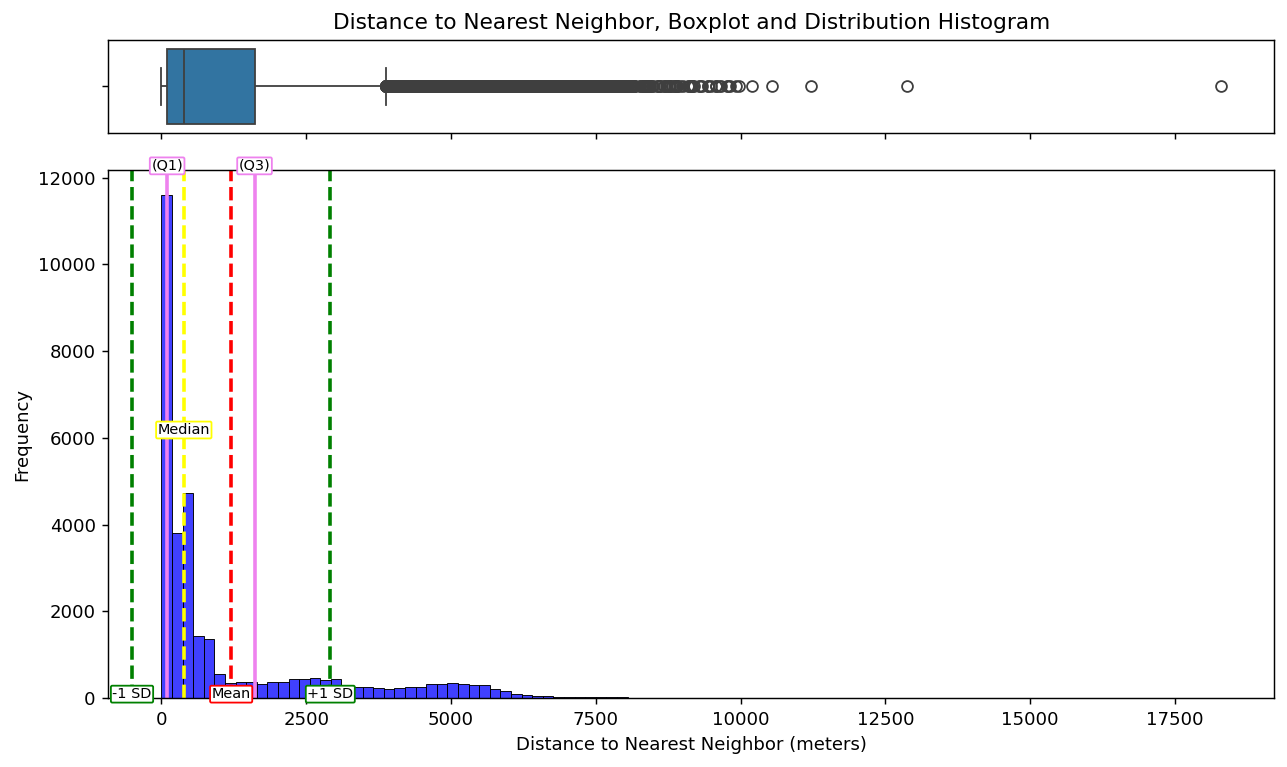

In [6]:
df_definer = gdata
data_definer = df_definer['nnd']
unit_definer = 'm'
title_definer = 'Distance to Nearest Neighbor, Boxplot and Distribution Histogram'
xlabel_deiner = 'Distance to Nearest Neighbor (meters)'
ylabel_definer = 'Frequency'
bins_definer = 100

total = len(df_definer)
maximum = data_definer.max()
minimum = data_definer.min()
mean = data_definer.mean()
median = data_definer.median()
Q1 = data_definer.quantile(0.25)
Q3 = data_definer.quantile(0.75)
std = data_definer.std()
Mode = data_definer.mode()[0]

# Print the results
print(f'Total data: {total}')
print(f'Higher data: {maximum:.0f} {unit_definer}')
print(f'Lower density: {minimum:.0f} {unit_definer}')
print(f'Mean density: {mean:.0f} {unit_definer}')
print(f'Median density: {median:.0f} {unit_definer}')
print(f'Mode density: {Mode:.0f} {unit_definer}')
print(f'Standard deviation: {std:.0f} {unit_definer}')
print(f'First quartile (Q1) density: {Q1:.0f} {unit_definer}')
print(f'Third quartile (Q3) density: {Q3:.0f} {unit_definer}')

fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(10, 6))

# Plotando o boxplot no primeiro eixo.
sns.boxplot(x=data_definer, ax=ax_box)
ax_box.set(xlabel='')
ax_box.set(title=title_definer)

# Plotando o histograma no segundo eixo.
sns.histplot(data_definer, ax=ax_hist, bins=bins_definer, kde=False, color='blue', edgecolor='black')

# Adicionando as linhas de média, mediana, etc, no histograma
ax_hist.axvline(Q1, color='violet', linestyle='solid', linewidth=2)
ax_hist.axvline(Q3, color='violet', linestyle='solid', linewidth=2)
ax_hist.axvline(median, color='yellow', linestyle='dashed', linewidth=2)
ax_hist.axvline(mean, color='red', linestyle='dashed', linewidth=2)
ax_hist.axvline(mean + std, color='green', linestyle='dashed', linewidth=2)
ax_hist.axvline(mean - std, color='green', linestyle='dashed', linewidth=2)

# Adicionando as legendas
ax_hist.text(Q1, plt.ylim()[1], '(Q1)', color='black', fontsize=8, ha='center',
             bbox=dict(facecolor='white', edgecolor='violet', boxstyle='round,pad=0.1'))
ax_hist.text(Q3, plt.ylim()[1], '(Q3)', color='black', fontsize=8, ha='center',
             bbox=dict(facecolor='white', edgecolor='violet', boxstyle='round,pad=0.1'))
ax_hist.text(median, plt.ylim()[1] * 0.5, 'Median', color='black', fontsize=8, ha='center',
             bbox=dict(facecolor='white', edgecolor='yellow', boxstyle='round,pad=0.1'))
ax_hist.text(mean, plt.ylim()[0] * 0.9, 'Mean', color='black', fontsize=8, ha='center',
             bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.1'))
ax_hist.text(mean + std, plt.ylim()[0] * 0.9, '+1 SD', color='black', fontsize=8, ha='center',
             bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.1'))
ax_hist.text(mean - std, plt.ylim()[0] * 0.9, '-1 SD', color='black', fontsize=8, ha='center',
             bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.1'))

# Configurando os rótulos e título para o histograma.
ax_hist.set(xlabel=xlabel_deiner, ylabel=ylabel_definer)

figure_path = "../paper/Figures/nnd.png"
fig.savefig(figure_path, dpi=300, bbox_inches="tight")
print(f"figura salva em: {figure_path}")
plt.tight_layout()
plt.show()

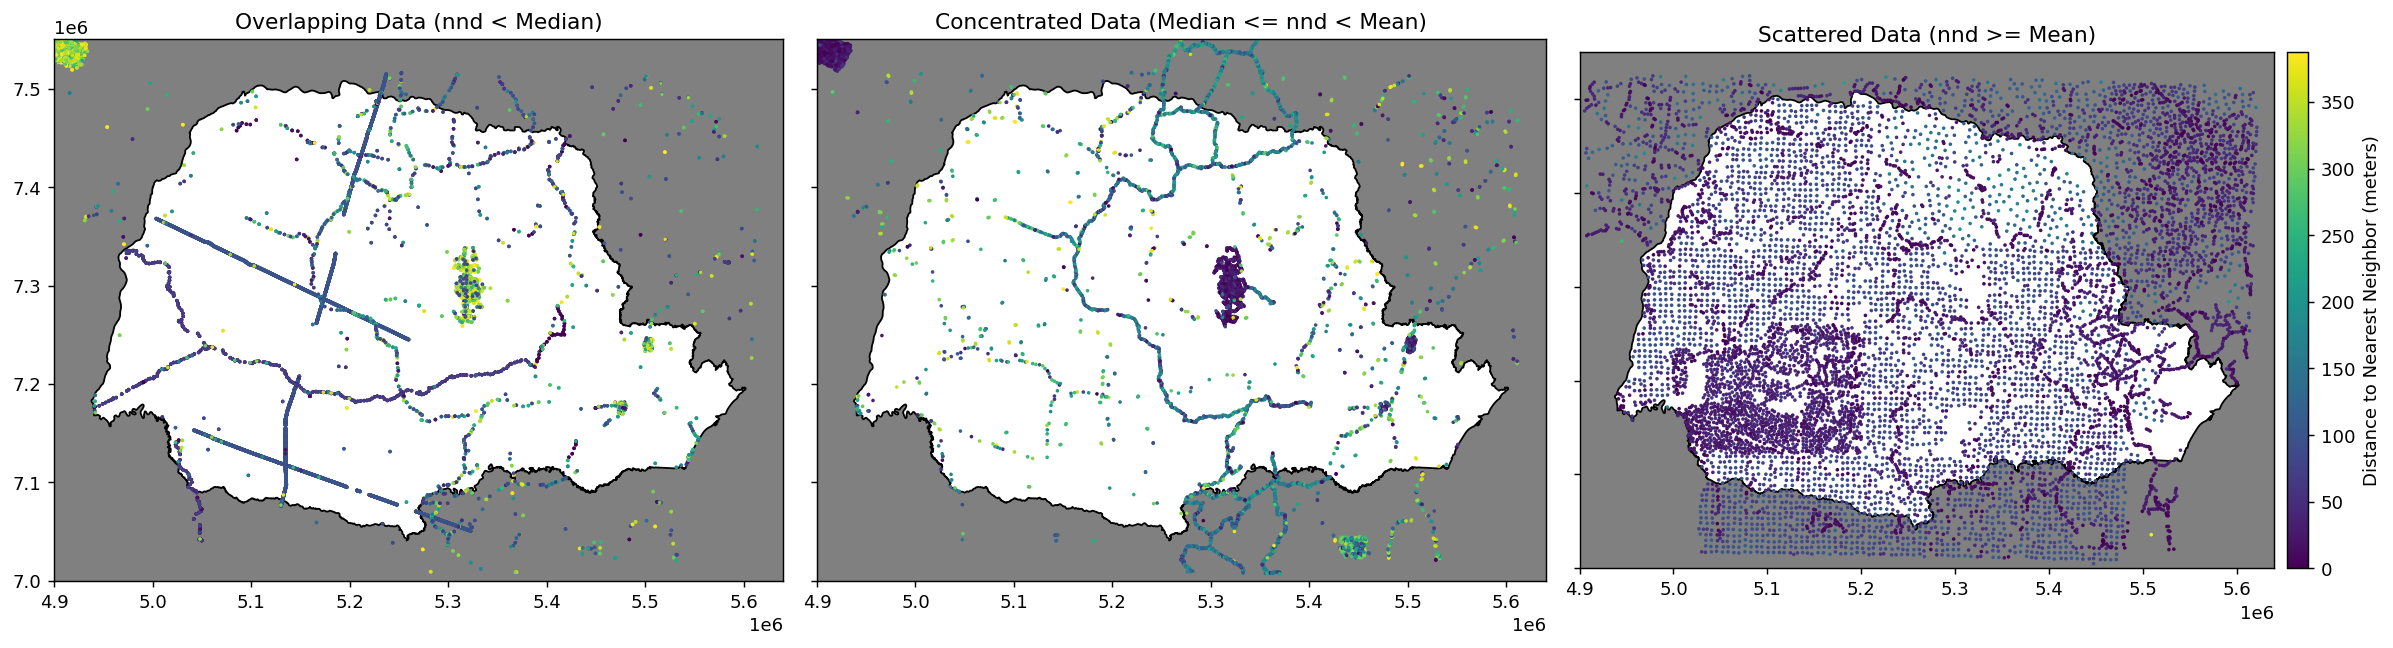

In [7]:
#Overlapping Data (nnd < Median)
overlapping_data = gdata[gdata['nnd'] < median].copy()

# Concentrated Data (Median <= nnd < Mean)
concentrated_data = gdata[(gdata['nnd'] >= median) & (gdata['nnd'] < mean)].copy()

# Scattered Data (nnd >= Mean)
scattered_data  = gdata[(gdata['nnd'] >= mean)].copy()

# Create a single figure and three subplots, side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# First subplot: Overlapping data
mask.plot(ax=axes[0], color='gray', edgecolor='none')
pr.plot(ax=axes[0], color='none', edgecolor='black')
scatter1 = axes[0].scatter(overlapping_data.x, overlapping_data.y, c=overlapping_data.nnd, s=1)
axes[0].set_title('Overlapping Data (nnd < Median)')

# Second subplot: Concentrated data
mask.plot(ax=axes[1], color='gray', edgecolor='none')
pr.plot(ax=axes[1], color='none', edgecolor='black')
scatter2 = axes[1].scatter(concentrated_data.x, concentrated_data.y, c=concentrated_data.nnd, s=1)
axes[1].set_title('Concentrated Data (Median <= nnd < Mean)')

# Third subplot: Scattered data
mask.plot(ax=axes[2], color='gray', edgecolor='none')
pr.plot(ax=axes[2], color='none', edgecolor='black')
scatter3 = axes[2].scatter(scattered_data.x, scattered_data.y, c=scattered_data.nnd, s=1)
axes[2].set_title('Scattered Data (nnd >= Mean)')

# Setting the same limits for all subplots
for ax in axes:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect("equal")

# Create a new division for the color bar
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="3%", pad=0.1)

# Placing a single color bar for all charts
plt.tight_layout()
plt.colorbar(scatter1, cax=cax, label="Distance to Nearest Neighbor (meters)")

plt.show()

Total data: 8987
Higher data: 18296 m
Lower density: 1206 m
Mean density: 3599 m
Median density: 3283 m
Mode density: 2215 m
Standard deviation: 1601 m
First quartile (Q1) density: 2295 m
Third quartile (Q3) density: 4887 m


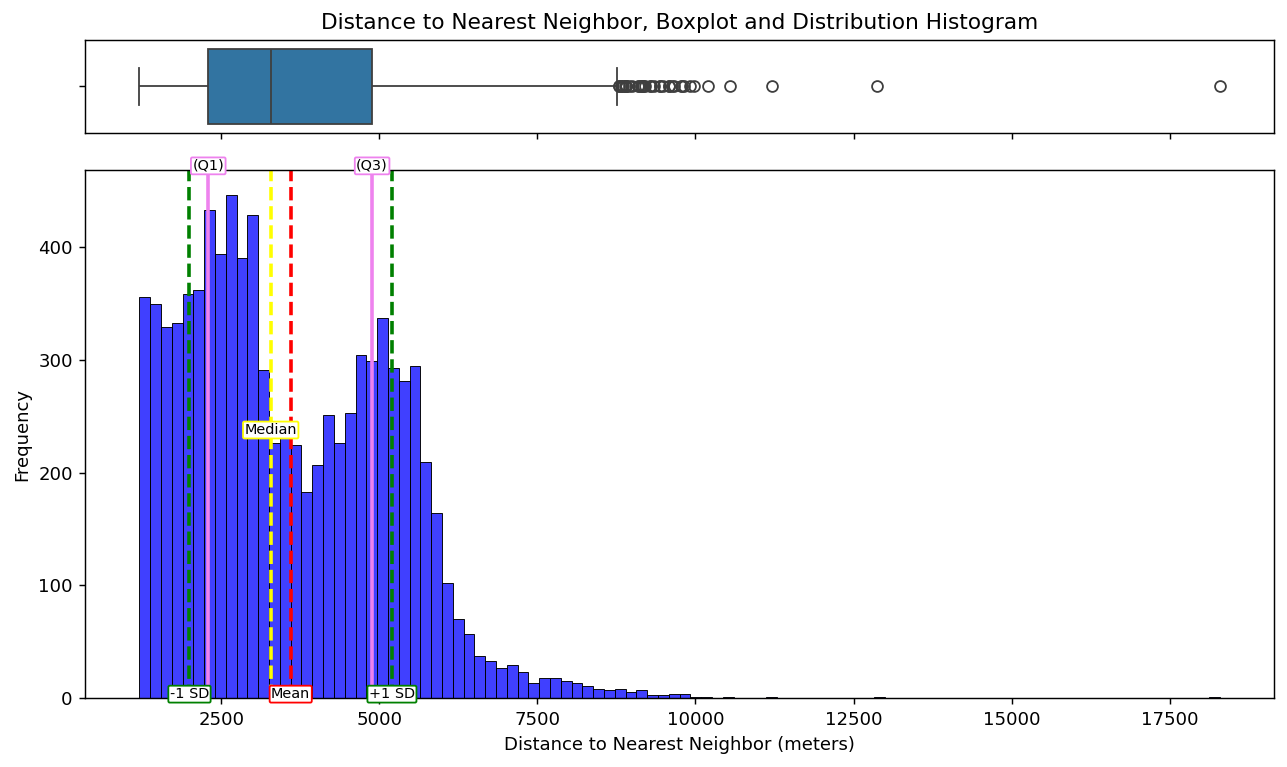

In [8]:
df_definer = scattered_data
data_definer = df_definer['nnd']
unit_definer = 'm'
title_definer = 'Distance to Nearest Neighbor, Boxplot and Distribution Histogram'
xlabel_deiner = 'Distance to Nearest Neighbor (meters)'
ylabel_definer = 'Frequency'
bins_definer = 100

total = len(df_definer)
maximum = data_definer.max()
minimum = data_definer.min()
mean = data_definer.mean()
median = data_definer.median()
Q1 = data_definer.quantile(0.25)
Q3 = data_definer.quantile(0.75)
std = data_definer.std()
Mode = data_definer.mode()[0]

# Print the results
print(f'Total data: {total}')
print(f'Higher data: {maximum:.0f} {unit_definer}')
print(f'Lower density: {minimum:.0f} {unit_definer}')
print(f'Mean density: {mean:.0f} {unit_definer}')
print(f'Median density: {median:.0f} {unit_definer}')
print(f'Mode density: {Mode:.0f} {unit_definer}')
print(f'Standard deviation: {std:.0f} {unit_definer}')
print(f'First quartile (Q1) density: {Q1:.0f} {unit_definer}')
print(f'Third quartile (Q3) density: {Q3:.0f} {unit_definer}')

fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(10, 6))

# Plotando o boxplot no primeiro eixo.
sns.boxplot(x=data_definer, ax=ax_box)
ax_box.set(xlabel='')
ax_box.set(title=title_definer)

# Plotando o histograma no segundo eixo.
sns.histplot(data_definer, ax=ax_hist, bins=bins_definer, kde=False, color='blue', edgecolor='black')

# Adicionando as linhas de média, mediana, etc, no histograma
ax_hist.axvline(Q1, color='violet', linestyle='solid', linewidth=2)
ax_hist.axvline(Q3, color='violet', linestyle='solid', linewidth=2)
ax_hist.axvline(median, color='yellow', linestyle='dashed', linewidth=2)
ax_hist.axvline(mean, color='red', linestyle='dashed', linewidth=2)
ax_hist.axvline(mean + std, color='green', linestyle='dashed', linewidth=2)
ax_hist.axvline(mean - std, color='green', linestyle='dashed', linewidth=2)

# Adicionando as legendas
ax_hist.text(Q1, plt.ylim()[1], '(Q1)', color='black', fontsize=8, ha='center',
             bbox=dict(facecolor='white', edgecolor='violet', boxstyle='round,pad=0.1'))
ax_hist.text(Q3, plt.ylim()[1], '(Q3)', color='black', fontsize=8, ha='center',
             bbox=dict(facecolor='white', edgecolor='violet', boxstyle='round,pad=0.1'))
ax_hist.text(median, plt.ylim()[1] * 0.5, 'Median', color='black', fontsize=8, ha='center',
             bbox=dict(facecolor='white', edgecolor='yellow', boxstyle='round,pad=0.1'))
ax_hist.text(mean, plt.ylim()[0] * 0.9, 'Mean', color='black', fontsize=8, ha='center',
             bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.1'))
ax_hist.text(mean + std, plt.ylim()[0] * 0.9, '+1 SD', color='black', fontsize=8, ha='center',
             bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.1'))
ax_hist.text(mean - std, plt.ylim()[0] * 0.9, '-1 SD', color='black', fontsize=8, ha='center',
             bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.1'))

# Configurando os rótulos e título para o histograma.
ax_hist.set(xlabel=xlabel_deiner, ylabel=ylabel_definer)
plt.tight_layout()
plt.show()

In [ ]:
## Build the grid using the verde.grid coordinates function from the Verde library and create the equivalent layer with the harmonica.EquivalentLayer class from the Harmonica library.

# Resolution is established as half the median distance to the nearest neighbor within the Scattered Data, rounded to the nearest and lowest multiple of 100.
pixel_grid = int(((scattered_data['nnd'].median()) / 2) // 100 * 100)

# Set Highest altitude
highest_altitude = gdata.h.max()

# Set data coordinates
coordinates = (gdata.x, gdata.y, gdata.h)

# Build the grid
grid_coords = vd.grid_coordinates(region=(xmin, xmax, ymin, ymax), spacing=pixel_grid, extra_coords=highest_altitude+1)

# Create the equivalent layer with the harmonica.EquivalentSources class from the Harmonica library
eql = hm.EquivalentSources(damping=1e2, depth=pixel_grid*3.5, block_size=pixel_grid)

print(f'Higher altitude: {highest_altitude}m')
print(f'Resolution: {pixel_grid}m')

# Obtaining Theoretical Gravity $γ_h$ and Gravity Disturbance $δ g$.

In [ ]:
# Defining an Ellipsoid
ellipsoid = bl.GRS80
ellipsoid

In [ ]:
# Getting theoretical gravity for the defined ellipsoid
gamma = ellipsoid.normal_gravity(gdata.LAT, gdata.h)

# Including theoretical gravity in the dataframe
gdata = gdata.assign(gamma=gamma)
gdata

Gravity Disturbance $δ g$ will be equal to measured gravity $g_{obs}$ minus Theoretical Gravity $γ_h$:

$ δ g = g_{obs} - γ_h $

In [ ]:
# Obtaining Gravity Disturbance
delta = gdata.g - gdata.gamma

# Including gravity disturbance in the dataframe
gdata = gdata.assign(delta=delta)
gdata

In [ ]:
# Plot gravit disturbance
fig, ax = plt.subplots(figsize=(8, 5))
mask.plot(ax=ax, color='gray', edgecolor='none')
pr.plot(ax=ax, color='none', edgecolor='black')
tmp = plt.scatter(gdata.x, gdata.y, c=gdata.delta, s=1)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

# Obtaining the Bouguer Disturbance $δ g_B$

In [ ]:
# Uploading topography
topography = '../data/raw/grav_data/cota.csv'
elevation = pd.read_csv(topography)

elevation

In [ ]:
df_definer = elevation
x_definer = df_definer['x']
y_definer = df_definer['y']
c_definer = df_definer['z']
unit_definer = 'm'
title_definer = 'FABDEM integrated with SRTM15+'


# Plot LTD
fig, ax = plt.subplots(figsize=(8, 5))
tmp = plt.scatter(x_definer, y_definer, c=c_definer, s=1)
mask.plot(ax=ax, color='gray', edgecolor='none')
pr.plot(ax=ax, color='none', edgecolor='black')
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label=unit_definer)
ax.set_title(title_definer)
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

In [ ]:
# Uploading lateral topographic density model for Paraná
LTD = '/content/drive/MyDrive/mesclar/LTD_PR.csv'
rho = pd.read_csv(LTD)

rho

In [ ]:
df_definer = rho
x_definer = df_definer['x']
y_definer = df_definer['y']
c_definer = df_definer['density']
unit_definer = 'kg/m³'
title_definer = 'Lateral Topographic Density Model, PR'

# Plot LTD
fig, ax = plt.subplots(figsize=(8, 5))
tmp = plt.scatter(x_definer, y_definer, c=c_definer, s=1)
mask.plot(ax=ax, color='gray', edgecolor='none')
pr.plot(ax=ax, color='none', edgecolor='black')
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label=unit_definer)
ax.set_title(title_definer)
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

In [ ]:
df_definer = rho
data_definer = df_definer['density']
unit_definer = 'kg/m³'
title_definer = 'Density Distribution Model (LTD_Brasil)'
xlabel_deiner = 'topographic density (kg/m³)'
ylabel_definer = 'Frequency'
bins_definer = 10

total = len(df_definer)
maximum = data_definer.max()
minimum = data_definer.min()
mean = data_definer.mean()
median = data_definer.median()
Q1 = data_definer.quantile(0.25)
Q3 = data_definer.quantile(0.75)
std = data_definer.std()
Mode = data_definer.mode()[0]

# Print the results
print(f'Total data: {total}')
print(f'Higher data: {maximum:.0f} {unit_definer}')
print(f'Lower density: {minimum:.0f} {unit_definer}')
print(f'Mean density: {mean:.0f} {unit_definer}')
print(f'Median density: {median:.0f} {unit_definer}')
print(f'Mode density: {Mode:.0f} {unit_definer}')
print(f'Standard deviation: {std:.0f} {unit_definer}')
print(f'First quartile (Q1) density: {Q1:.0f} {unit_definer}')
print(f'Third quartile (Q3) density: {Q3:.0f} {unit_definer}')

fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(10, 6))

# Plotando o boxplot no primeiro eixo.
sns.boxplot(x=data_definer, ax=ax_box)
ax_box.set(xlabel='')
ax_box.set(title=title_definer)

# Plotando o histograma no segundo eixo.
sns.histplot(data_definer, ax=ax_hist, bins=bins_definer, kde=False, color='blue', edgecolor='black')

# Adicionando as linhas de média, mediana, etc, no histograma
ax_hist.axvline(Q1, color='violet', linestyle='solid', linewidth=2)
ax_hist.axvline(Q3, color='violet', linestyle='solid', linewidth=2)
ax_hist.axvline(median, color='yellow', linestyle='dashed', linewidth=2)
ax_hist.axvline(mean, color='red', linestyle='dashed', linewidth=2)
ax_hist.axvline(mean + std, color='green', linestyle='dashed', linewidth=2)
ax_hist.axvline(mean - std, color='green', linestyle='dashed', linewidth=2)

# Adicionando as legendas
ax_hist.text(Q1, plt.ylim()[1], '(Q1)', color='black', fontsize=8, ha='center',
             bbox=dict(facecolor='white', edgecolor='violet', boxstyle='round,pad=0.1'))
ax_hist.text(Q3, plt.ylim()[1], '(Q3)', color='black', fontsize=8, ha='center',
             bbox=dict(facecolor='white', edgecolor='violet', boxstyle='round,pad=0.1'))
ax_hist.text(median, plt.ylim()[1] * 0.5, 'Median', color='black', fontsize=8, ha='center',
             bbox=dict(facecolor='white', edgecolor='yellow', boxstyle='round,pad=0.1'))
ax_hist.text(mean, plt.ylim()[0] * 0.9, 'Mean', color='black', fontsize=8, ha='center',
             bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.1'))
ax_hist.text(mean + std, plt.ylim()[0] * 0.9, '+1 SD', color='black', fontsize=8, ha='center',
             bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.1'))
ax_hist.text(mean - std, plt.ylim()[0] * 0.9, '-1 SD', color='black', fontsize=8, ha='center',
             bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.1'))

# Configurando os rótulos e título para o histograma.
ax_hist.set(xlabel=xlabel_deiner, ylabel=ylabel_definer)
plt.tight_layout()
plt.show()

In [ ]:
# define a density for the prisms
ρ = round(rho['density'].mean())  # kg/m³
print(f'Density: {ρ}kg/m³')

In [ ]:
df = elevation

# Create the xarray.Dataset with the dimensions explicitly defined
topography = xr.Dataset.from_dataframe(df.set_index(['y', 'x']))
topography['x'].attrs['units'] = 'metros'
topography['x'].attrs['standard_name'] = 'x'
topography['y'].attrs['units'] = 'metros'
topography['y'].attrs['standard_name'] = 'y'
topography['z'].attrs['units'] = 'metros'

# Convert two-dimensional coordinates to one-dimensional
easting = np.linspace(np.min(topography['x'].values), np.max(topography['x'].values), topography['x'].size)
northing = np.linspace(np.min(topography['y'].values), np.max(topography['y'].values), topography['y'].size)
prisms_centers = (easting, northing)
surface=topography['z'].values

# Density calculation for prisms
density = np.where(topography['z'].values >= 0, ρ, 1040 - ρ)

topo_prisms = hm.prism_layer(
    prisms_centers,
    surface,
    reference=0,
    properties={"density": density}
)

topo_prisms

In [ ]:
# Use "prism_layer" to calculate the layer's gravitational field
result = topo_prisms.prism_layer.gravity(coordinates, field="g_z")

# Calculate the bouguer disturbance
bouguer_disturbance = gdata.delta - result

# Add the bouguer disturbance to the dataset as a column
gdata = gdata.assign(bouguer_disturbance=bouguer_disturbance)


# Save the data to a CSV file, specify the path in google drive
file_path = '/content/drive/MyDrive/dados_geofisicos/saida/dados_mean.csv'
gdata.to_csv(file_path, index=False)
print(f'.csv file saved in: {file_path}')

#________________________________________________________________________________

# Grid the bouguer disturbance
eql.fit(coordinates, gdata.bouguer_disturbance)
grid = eql.grid(grid_coords, data_names=["bouguer_disturbance"])

# Set the SRC on the dataset
crs_code = 'EPSG:5880'
grid.attrs['crs'] = pyproj.CRS.from_string(crs_code).to_proj4()

grid

# Save the grid to a GeoTIFF file
data_variable = grid['bouguer_disturbance']
easting = grid['easting'].values
northing = grid['northing'].values
policone_crs = '+proj=poly +lat_0=0 +lon_0=-54 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs'
transform = Affine.translation(easting[0], northing[0]) * Affine.scale(easting[1] - easting[0], northing[1] - northing[0])
output_geotiff = '/content/drive/MyDrive/dados_geofisicos/saida/bouguer_mean.tif'
with rasterio.open(output_geotiff, 'w', driver='GTiff', height=data_variable.shape[0], width=data_variable.shape[1], count=1, dtype=data_variable.dtype, crs=policone_crs, transform=transform) as dst:
    dst.write(data_variable, 1)
print(f'GeoTIFF file saved in: {output_geotiff}')

# Save the grid to a NetCDF file
NetCDF = '/content/drive/MyDrive/dados_geofisicos/saida/bouguer_mean.nc'
grid.to_netcdf(NetCDF)
print(f'NetCDF file saved in: {NetCDF}')

In [ ]:
# Plot the grid

grid_definer = grid
variable_definer = grid_definer['bouguer_disturbance']
title_definer = 'Bouguer Disturbance PR'

fig, ax = plt.subplots(figsize=(8, 5))
variable_definer.plot(ax=ax, cmap='RdBu_r')
mask.plot(ax=ax, color='gray', edgecolor='none')
pr.plot(ax=ax, color='none', edgecolor='black')
ax.set_title(title_definer)
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

In [ ]:
# Remover a coordenada 'upward'
grid = grid.drop('upward')


# Calcular a derivada na direção leste usando diferenças finitas
derivada_leste = hm.derivative_easting(grid['bouguer_disturbance'], order=1, method='finite-diff')

# Renomear a variável no DataArray
derivada_leste = derivada_leste.rename('derivative_easting')

# Plotar o xarray.DataArray usando pcolormesh
fig, ax = plt.subplots(figsize=(8, 5))
plt.pcolormesh(derivada_leste['easting'], derivada_leste['northing'], derivada_leste.values, cmap='viridis')

# Plotar o shapefile
mask.plot(ax=ax, color='gray', edgecolor='none')
pr.plot(ax=ax, color='none', edgecolor='black')

# Configurações adicionais
plt.colorbar(label= 'Derivative Easting')
ax.set_title('Derivative Easting PR')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_aspect('equal', adjustable='box')

# Ajustar os limites para o zoom
xmin, xmax, ymin, ymax = 4.9e6, 5.64e6, 7e6, 7.55e6
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

In [ ]:
# Calcular a derivada na direção norte usando diferenças finitas
derivada_norte = hm.derivative_northing(grid['bouguer_disturbance'], order=1, method='finite-diff')

# Renomear a variável no DataArray
derivada_norte = derivada_norte.rename('derivative_northing')

# Plotar o xarray.DataArray usando pcolormesh
fig, ax = plt.subplots(figsize=(8, 5))
plt.pcolormesh(derivada_norte['easting'], derivada_norte['northing'], derivada_norte.values, cmap='viridis')

# Plotar o shapefile
mask.plot(ax=ax, color='gray', edgecolor='none')
pr.plot(ax=ax, color='none', edgecolor='black')

# Configurações adicionais
plt.colorbar(label= 'Derivative Northing')
ax.set_title('Derivative Northing PR')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_aspect('equal', adjustable='box')

# Ajustar os limites para o zoom
xmin, xmax, ymin, ymax = 4.9e6, 5.64e6, 7e6, 7.55e6
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

In [ ]:
# Calcular a derivada ascendente
derivada_ascendente = hm.derivative_upward(grid['bouguer_disturbance'], order=1)

# Dê um nome à sua variável no DataArray
derivada_ascendente.name = 'derivative_upward'

# Plotar o xarray.DataArray usando pcolormesh
fig, ax = plt.subplots(figsize=(8, 5))
plt.pcolormesh(derivada_ascendente['easting'], derivada_ascendente['northing'], derivada_ascendente.values, cmap='viridis')

# Plotar o shapefile
mask.plot(ax=ax, color='gray', edgecolor='none')
pr.plot(ax=ax, color='none', edgecolor='black')

# Configurações adicionais
plt.colorbar(label= 'Derivative Upward')
ax.set_title('Derivative Upward PR')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_aspect('equal', adjustable='box')

# Ajustar os limites para o zoom
xmin, xmax, ymin, ymax = 4.9e6, 5.64e6, 7e6, 7.55e6
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

In [ ]:
# Calcular o gradiente horizontal total
GHT = ((derivada_leste**2 + derivada_norte**2)**0.5)*1000

# Dê um nome à sua variável no DataArray
GHT.name = 'GHT'

# Plotar o xarray.DataArray usando pcolormesh
fig, ax = plt.subplots(figsize=(8, 5))
plt.pcolormesh(GHT['easting'], GHT['northing'], GHT.values, cmap='viridis')

# Plotar o shapefile
mask.plot(ax=ax, color='gray', edgecolor='none')
pr.plot(ax=ax, color='none', edgecolor='black')

# Configurações adicionais
plt.colorbar(label= 'GHT')
ax.set_title('GHT PR')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_aspect('equal', adjustable='box')

# Ajustar os limites para o zoom
xmin, xmax, ymin, ymax = 4.9e6, 5.64e6, 7e6, 7.55e6
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

In [ ]:
# Sincronizar explicitamente as coordenadas entre os DataArrays
derivada_ascendente = derivada_ascendente.assign_coords(easting=derivada_leste['easting'], northing=derivada_leste['northing'])
derivada_norte = derivada_norte.assign_coords(easting=derivada_leste['easting'], northing=derivada_leste['northing'])

# Calcular a Inclinação do Sinal Analítico (ISA)
ISA = np.arctan(derivada_ascendente / np.sqrt(derivada_leste**2 + derivada_norte**2))

# Dê um nome à sua variável no DataArray
ISA.name = 'ISA'

# Plotar o xarray.DataArray usando pcolormesh
fig, ax = plt.subplots(figsize=(8, 5))
plt.pcolormesh(ISA['easting'], ISA['northing'], ISA.values, cmap='viridis')

# Plotar o shapefile
mask.plot(ax=ax, color='gray', edgecolor='none')
pr.plot(ax=ax, color='none', edgecolor='black')

# Configurações adicionais
plt.colorbar(label= 'ISA')
ax.set_title('ISA PR')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_aspect('equal', adjustable='box')

# Ajustar os limites para o zoom
xmin, xmax, ymin, ymax = 4.9e6, 5.64e6, 7e6, 7.55e6
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

In [ ]:
# Grid the gravit disturbances
eql.fit(coordinates, gdata.delta)
gridgd = eql.grid(grid_coords, data_names=["gravit_disturbance"])

# Set the SRC on the dataset
crs_code = 'EPSG:5880'
gridgd.attrs['crs'] = pyproj.CRS.from_string(crs_code).to_proj4()

# Save the grid to a GeoTIFF file
data_variable = gridgd['gravit_disturbance']
easting = gridgd['easting'].values
northing = gridgd['northing'].values
policone_crs = '+proj=poly +lat_0=0 +lon_0=-54 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs'
transform = Affine.translation(easting[0], northing[0]) * Affine.scale(easting[1] - easting[0], northing[1] - northing[0])
output_geotiff = '/content/drive/MyDrive/dados_geofisicos/saida/gravit_disturbancePR.tif'
with rasterio.open(output_geotiff, 'w', driver='GTiff', height=data_variable.shape[0], width=data_variable.shape[1], count=1, dtype=data_variable.dtype, crs=policone_crs, transform=transform) as dst:
    dst.write(data_variable, 1)
print(f'GeoTIFF file saved in: {output_geotiff}')

# Save the grid to a NetCDF file
NetCDF = '/content/drive/MyDrive/dados_geofisicos/saida/gravit_disturbancePR.nc'
gridgd.to_netcdf(NetCDF)
print(f'NetCDF file saved in: {NetCDF}')

# Plot the grid
fig, ax = plt.subplots(figsize=(8, 5))
gridgd.gravit_disturbance.plot(ax=ax, cmap='RdBu_r')
mask.plot(ax=ax, color='gray', edgecolor='none')
pr.plot(ax=ax, color='none', edgecolor='black')
ax.set_title('Gravit Disturbance PR')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

In [ ]:
# Obtenha os valores do xarray.DataArray ISA
dados_ISA = ISA.values

# Obtenha as coordenadas do xarray.DataArray ISA
easting = ISA.easting.values
northing = ISA.northing.values

# Defina o SRC para o sistema SIRGAS 2000 / Brazil Polyconic
policone_crs = '+proj=poly +lat_0=0 +lon_0=-54 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs'

# Defina a transformação usando as coordenadas
transform = Affine.translation(easting[0], northing[0]) * Affine.scale(easting[1] - easting[0], northing[1] - northing[0])

# Escreva os dados no arquivo GeoTIFF
output_geotiff = '/content/drive/MyDrive/dados_geofisicos/saida/ISAmean.tif'
with rasterio.open(output_geotiff, 'w', driver='GTiff', height=dados_ISA.shape[0], width=dados_ISA.shape[1], count=1, dtype=dados_ISA.dtype, crs=policone_crs, transform=transform) as dst:
    dst.write(dados_ISA, 1)

In [ ]:
# Obtenha os valores do xarray.DataArray GHT
dados_GHT = GHT.values

# Obtenha as coordenadas do xarray.DataArray GHT
easting = GHT.easting.values
northing = GHT.northing.values

# Defina o SRC para o sistema SIRGAS 2000 / Brazil Polyconic
policone_crs = '+proj=poly +lat_0=0 +lon_0=-54 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs'

# Defina a transformação usando as coordenadas
transform = Affine.translation(easting[0], northing[0]) * Affine.scale(easting[1] - easting[0], northing[1] - northing[0])

# Escreva os dados no arquivo GeoTIFF
output_geotiff = '/content/drive/MyDrive/dados_geofisicos/saida/GHTmean.tif'
with rasterio.open(output_geotiff, 'w', driver='GTiff', height=dados_GHT.shape[0], width=dados_GHT.shape[1], count=1, dtype=dados_GHT.dtype, crs=policone_crs, transform=transform) as dst:
    dst.write(dados_GHT, 1)